<a href="https://colab.research.google.com/github/VijayaBhargavi198/5731Assignments/blob/master/LDA_TopicModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy-langdetect
!pip install language-detector
!pip install symspellpy
!pip install sentence-transformers
!pip install pysbd
!pip install pyLDAvis

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim imports
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import pandas as pd
df=pd.read_csv("/content/sample_data/guardian_headlines.csv")
input_df= df.head(100)
input_df.head(5)

,Time,Headlines
0,18-Jul-20,Johnson is asking Santa for a Christmas recovery
1,18-Jul-20,‘I now fear the worst’: four grim tales of wor...
2,18-Jul-20,Five key areas Sunak must tackle to serve up e...
3,18-Jul-20,Covid-19 leaves firms ‘fatally ill-prepared’ f...
4,18-Jul-20,The Week in Patriarchy \n\n\n Bacardi's 'lad...


In [ ]:
5#PREPROCESSING
#changing the whole list into smallercase
input_df["Headlines"] = input_df["Headlines"].str.lower()
#converting the dataframe to list
data = input_df["Headlines"].values.tolist()
#Remove new line character
data = [re.sub(' $','',sent) for sent in data]
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
#Remove single quotes
data = [re.sub('\s+',' ',sent) for sent in data]
#Remove colons
data = [re.sub(':','',sent) for sent in data]
#Remove hipens fron hipenated words
data = [re.sub('-','',sent) for sent in data]
print(data[:5])

['johnson is asking santa for a christmas recovery', '‘i now fear the worst’ four grim tales of working life upended by covid19', 'five key areas sunak must tackle to serve up economic recovery', 'covid19 leaves firms ‘fatally illprepared’ for nodeal brexit', "the week in patriarchy bacardi's 'lady vodka' the latest in a long line of depressing gendered products"]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
import nltk; 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stemmer=PorterStemmer()
# list for tokenized documents in loop
texts = []

# loop through document list
for i in data:
    
    # tokenize document string
    tokens = word_tokenize(i)

    # remove stop words from tokens
    stop_words = set(stopwords.words('english')) 
    stopped_tokens = [i for i in tokens if not i in stop_words]
    
    # stem tokens
    stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)
texts

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[['johnson', 'ask', 'santa', 'christma', 'recoveri'],
 ['‘',
  'fear',
  'worst',
  '’',
  'four',
  'grim',
  'tale',
  'work',
  'life',
  'upend',
  'covid19'],
 ['five',
  'key',
  'area',
  'sunak',
  'must',
  'tackl',
  'serv',
  'econom',
  'recoveri'],
 ['covid19',
  'leav',
  'firm',
  '‘',
  'fatal',
  'illprepar',
  '’',
  'nodeal',
  'brexit'],
 ['week',
  'patriarchi',
  'bacardi',
  "'s",
  "'ladi",
  'vodka',
  "'",
  'latest',
  'long',
  'line',
  'depress',
  'gender',
  'product'],
 ['english', 'council', 'call', 'smoke', 'ban', 'outsid', 'pub', 'cafe'],
 ['tesla', 'justifi', '$', '300bn', 'valuat', '?'],
 ['empti', 'citi', 'centr', "'i", '’', 'sure', 'ever', "'"],
 ['democratis',
  'financ',
  '?',
  'invest',
  'app',
  'amateur',
  'student',
  'trader',
  "'s",
  'death'],
 ['homebuy', 'lose', '£300,000', 'fraudster', '–', 'get', 'back', 'step'],
 ['st', 'maw', 'name', 'uk', '’', 'top', 'seasid', 'resort', '?', 'poll'],
 ['atol', 'protect', 'extend', 'voucher', 

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[texts], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[texts[10]]])

['st', 'maw', 'name', 'uk', '’', 'top', 'seasid', 'resort', '?', 'poll']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
# Form Bigrams
data_words_bigrams = make_bigrams(texts)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:10])

[['ask'], ['fear', 'bad', 'grim', 'tale', 'work', 'upend', 'covid19'], ['key', 'area', 'sunak', 'must', 'tackl'], ['firm', 'fatal', 'illprepar'], ['week', 'bacardi', 'ladi', 'vodka', 'late', 'long', 'line', 'depress', 'gender', 'product'], [], ['valuat'], ['ever'], ['invest', 'student', 'trader', 'death'], ['lose', 'fraudster', 'back', 'step']]


In [ ]:
  # Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [ ]:
id2word[0]

'ask'

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:20]]

[[('ask', 1)],
 [('bad', 1),
  ('covid19', 1),
  ('fear', 1),
  ('grim', 1),
  ('tale', 1),
  ('upend', 1),
  ('work', 1)],
 [('area', 1), ('key', 1), ('must', 1), ('sunak', 1), ('tackl', 1)],
 [('fatal', 1), ('firm', 1), ('illprepar', 1)],
 [('bacardi', 1),
  ('depress', 1),
  ('gender', 1),
  ('ladi', 1),
  ('late', 1),
  ('line', 1),
  ('long', 1),
  ('product', 1),
  ('vodka', 1),
  ('week', 1)],
 [],
 [('valuat', 1)],
 [('ever', 1)],
 [('death', 1), ('invest', 1), ('student', 1), ('trader', 1)],
 [('back', 1), ('fraudster', 1), ('lose', 1), ('step', 1)],
 [('name', 1), ('poll', 1), ('resort', 1), ('seasid', 1), ('top', 1)],
 [('extend', 1), ('voucher', 1)],
 [('clothe', 1), ('grenfellstyl', 1), ('remov', 1)],
 [('call', 1), ('factori', 1), ('fit', 1), ('scheme', 1), ('trade', 1)],
 [('week', 1), ('least', 1), ('offic', 1), ('staff', 1), ('tell', 1)],
 [('ask', 1), ('close', 1), ('job', 1), ('outlet', 1), ('threaten', 1)],
 [],
 [('call', 1),
  ('creditor', 1),
  ('cut', 1),
  ('de

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"storm" + 0.020*"wealthi" + 0.020*"effect" + 0.020*"price" + '
  '0.020*"coronaviru" + 0.020*"chain" + 0.020*"increa" + 0.020*"ride" + '
  '0.020*"vat" + 0.020*"superrich"'),
 (1,
  '0.077*"plan" + 0.052*"coronaviru" + 0.052*"save" + 0.052*"set" + '
  '0.052*"toxic" + 0.052*"bodi" + 0.052*"debt" + 0.052*"busi" + 0.027*"town" + '
  '0.027*"transform"'),
 (2,
  '0.033*"claim" + 0.033*"big" + 0.017*"problem" + 0.017*"chine" + 0.017*"%" + '
  '0.017*"late" + 0.017*"far" + 0.017*"leave" + 0.017*"pain" + 0.017*"tackl"'),
 (3,
  '0.030*"least" + 0.030*"era" + 0.030*"search" + 0.030*"tell" + '
  '0.030*"tourist" + 0.030*"staff" + 0.030*"offic" + 0.030*"could" + '
  '0.030*"highrisk" + 0.030*"randomli"'),
 (4,
  '0.039*"tax" + 0.020*"extend" + 0.020*"voucher" + 0.020*"product" + '
  '0.020*"week" + 0.020*"late" + 0.020*"line" + 0.020*"long" + 0.020*"gender" '
  '+ 0.020*"unemploy"'),
 (5,
  '0.057*"cut" + 0.043*"job" + 0.029*"say" + 0.029*"crisi" + 0.029*"vat" + '
  '0.015*"oil" +

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.823695076647259

Coherence Score:  0.4837868844551254


In [ ]:
 !pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/Program Files/Java/jdk-14"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.9" 2020-10-20
OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('unemploy', 0.09090909090909091),
   ('bodi', 0.06060606060606061),
   ('staff', 0.06060606060606061),
   ('rule', 0.06060606060606061),
   ('fraudster', 0.030303030303030304),
   ('outlet', 0.030303030303030304),
   ('audit', 0.030303030303030304),
   ('network', 0.030303030303030304),
   ('mood', 0.030303030303030304),
   ('gambler', 0.030303030303030304)]),
 (1,
  [('cut', 0.23684210526315788),
   ('lockdown', 0.07894736842105263),
   ('transform', 0.02631578947368421),
   ('fuel', 0.02631578947368421),
   ('union', 0.02631578947368421),
   ('pack', 0.02631578947368421),
   ('death', 0.02631578947368421),
   ('push', 0.02631578947368421),
   ('late', 0.02631578947368421),
   ('payment', 0.02631578947368421)]),
 (2,
  [('plan', 0.125),
   ('debt', 0.1),
   ('call', 0.075),
   ('financ', 0.05),
   ('ethic', 0.05),
   ('toxic', 0.05),
   ('busi', 0.05),
   ('valuat', 0.025),
   ('world', 0.025),
   ('cost', 0.025)]),
 (3,
  [('risk', 0.06451612903225806),
   ('appl', 0.0645161

In [ ]:
 def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


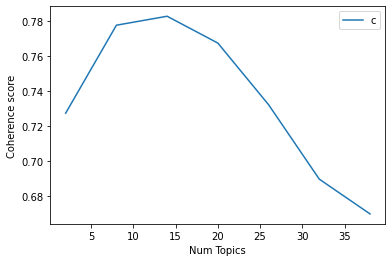

In [ ]:
  limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()